# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!curl -L -o ./training/training1.zip https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!curl -L -o ./training/training2.zip https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!curl -L -o ./training/holdout.zip https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!curl -L -o ./training/mini_holdout.zip https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!curl -L -o ./training/mini_holdout_answers.csv https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!tar -xf ./training/training1.zip -C ./training
!tar -xf ./training/training2.zip -C ./training
!tar -xf ./training/holdout.zip -C ./training
!tar -xf ./training/mini_holdout.zip -C ./training

# Combine the two training directories
!echo "Merging training data..."
!mkdir -p ./training/combined_training
# Use xcopy instead of move for Windows
!xcopy /E /I /Y .\training\training1\* .\training\combined_training
!xcopy /E /I /Y .\training\training2\* .\training\combined_training

# Cleanup
!echo "Cleaning up..."
# For non-empty directories, use rmdir /s /q (Windows equivalent of rm -rf)
!rmdir /s /q .\training\training1
!rmdir /s /q .\training\training2
# For file deletion, use del with proper path syntax
!del .\training\training1.zip
!del .\training\training2.zip
!del .\training\holdout.zip
!del .\training\mini_holdout.zip

!echo "Data ready."

In [1]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Get a list of GPU devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # After enabling memory growth, we need to make sure TensorFlow sees the updated configuration
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")

1 Physical GPUs, 1 Logical GPUs


In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.

# Use forward slashes for paths - works on all platforms including Windows
training_dir = './training/combined_training'
image_size = (100, 100)

# Create a single ImageDataGenerator with our configurations
data_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
        )

# Create separate generators for training and validation from the same ImageDataGenerator
train_generator = data_generator.flow_from_directory(
        training_dir,
        target_size=image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,
        shuffle=True)

validation_generator = data_generator.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

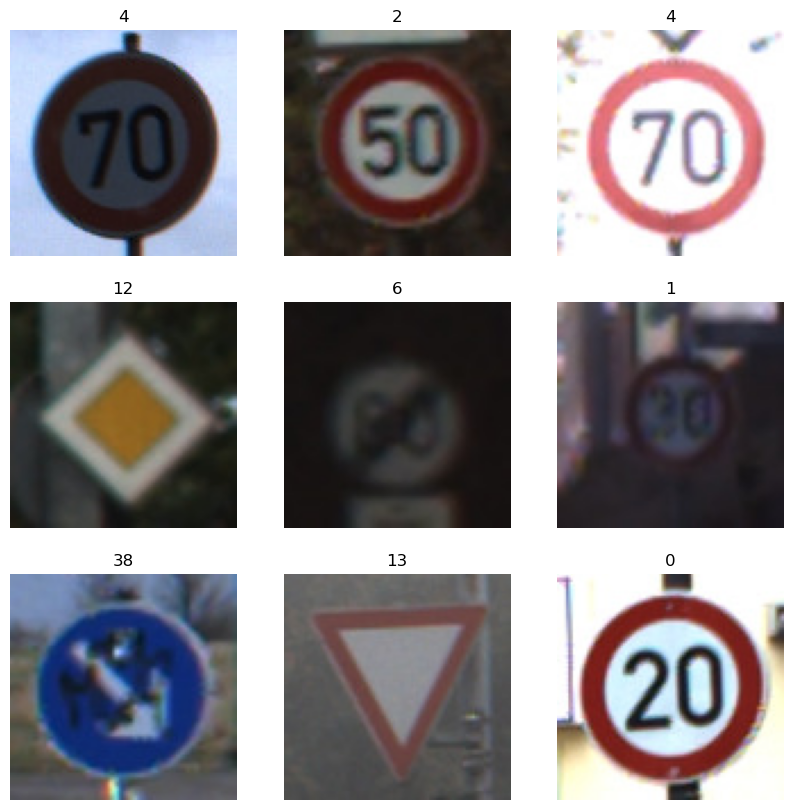

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [ ]:
# Build a model...

# Load the pretrained ResNet-50 without top layers.
base_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Adding custom layers on the pretrained model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(target_names))  # Output layer
])

#Compile the model
model.compile(optimizer = Adam(learning_rate=1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

model.summary()

# Check your class count
print(f"Number of classes in train_generator: {len(train_generator.class_indices)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                11051     
Total params: 24,123,307
Trainable params: 24,070,187
Non-trainable params: 53,120
_________________________________________________________________
Number of classes in train_generator: 43


In [7]:
# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',     # Path to save the best model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
981/981 [==============================] - 45s 37ms/step - loss: 0.3662 - accuracy: 0.9060 - val_loss: 0.3102 - val_accuracy: 0.9299

Epoch 00001: val_loss improved from inf to 0.31018, saving model to best_model.h5


c:\Users\austb\anaconda3\envs\resnet_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
981/981 [==============================] - 33s 33ms/step - loss: 0.0347 - accuracy: 0.9918 - val_loss: 0.3990 - val_accuracy: 0.9397

Epoch 00002: val_loss did not improve from 0.31018
Epoch 3/10
981/981 [==============================] - 33s 33ms/step - loss: 0.0182 - accuracy: 0.9959 - val_loss: 0.1651 - val_accuracy: 0.9605

Epoch 00003: val_loss improved from 0.31018 to 0.16511, saving model to best_model.h5
Epoch 4/10
981/981 [==============================] - 33s 34ms/step - loss: 0.0253 - accuracy: 0.9947 - val_loss: 0.0904 - val_accuracy: 0.9777

Epoch 00004: val_loss improved from 0.16511 to 0.09039, saving model to best_model.h5
Epoch 5/10
981/981 [==============================] - 33s 34ms/step - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.0859 - val_accuracy: 0.9801

Epoch 00005: val_loss improved from 0.09039 to 0.08586, saving model to best_model.h5
Epoch 6/10
981/981 [==============================] - 33s 34ms/step - loss: 0.0193 - accuracy: 0.9962 - val_los

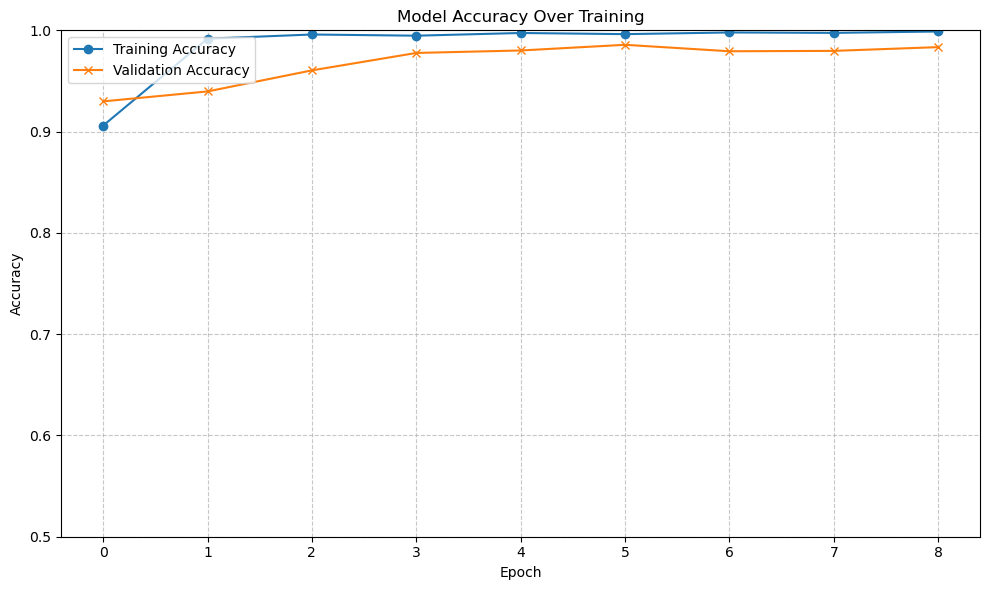

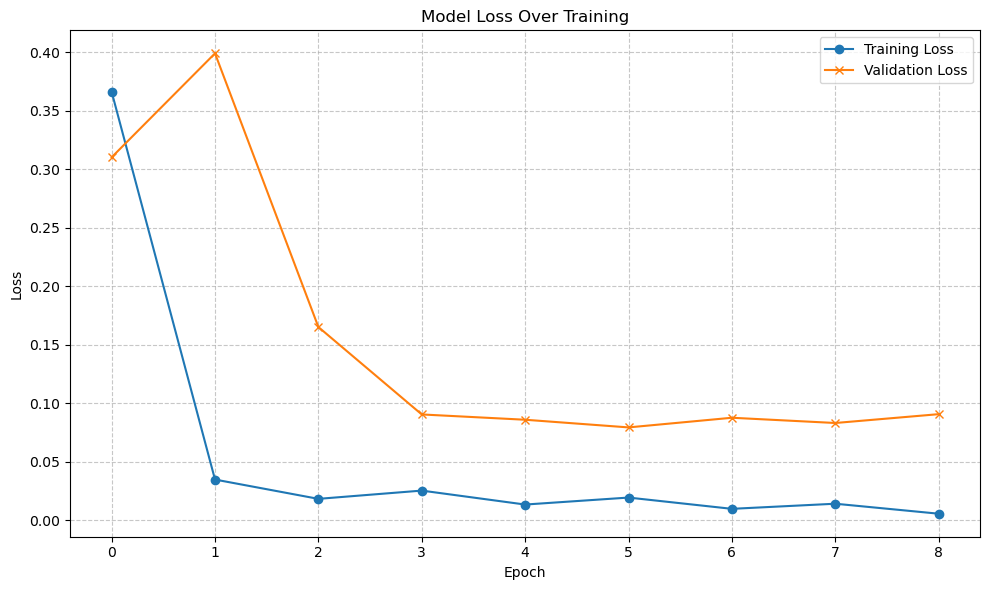

246/246 - 2s - loss: 0.0793 - accuracy: 0.9857
Test accuracy: 0.9857
Test loss: 0.0793


In [8]:
# Create a new figure with a specific size
plt.figure(figsize=(10, 6))

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Training')
plt.ylim([0.50, 1])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')

# Force display the plot
plt.tight_layout()
plt.show()

# Create a new figure for loss
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Training')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

# Force display the plot
plt.tight_layout()
plt.show()

# Print evaluation metrics
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = './training'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]



Found 201 images belonging to 1 classes.


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Read the ground truth CSV file
ground_truth = pd.read_csv('./training/mini_holdout_answers.csv')

# Extract just the class IDs in the same order as the CSV
true_labels = ground_truth['ClassId'].values

# Check if we have the same number of predictions as ground truth labels
if len(predictions) != len(true_labels):
    print(f"Warning: Number of predictions ({len(predictions)}) doesn't match number of ground truth labels ({len(true_labels)})")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Filename': ground_truth['Filename'],
    'Actual': true_labels,
    'Predicted': predictions[:len(true_labels)]  # In case there's a mismatch
})

# Find matches and mismatches
comparison['Correct'] = comparison['Actual'] == comparison['Predicted']

# Display results
print(f"Total images: {len(comparison)}")
print(f"Model accuracy: {accuracy:.4f} ({int(accuracy*len(comparison))}/{len(comparison)})")
print("\nSample of predictions vs ground truth:")
print(comparison.head(20))

# Show incorrectly classified images
print("\nSample of incorrect predictions:")
print(comparison[~comparison['Correct']].head(20))

# Show a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions[:len(true_labels)]))

# Show most confused classes
print("\nMost confused classes:")
incorrect = comparison[~comparison['Correct']]
confused_pairs = incorrect.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
confused_pairs = confused_pairs.sort_values('Count', ascending=False)
print(confused_pairs.head(10))

Total images: 201
Model accuracy: 0.9751 (196/201)

Sample of predictions vs ground truth:
     Filename  Actual  Predicted  Correct
0   00000.jpg      16         16     True
1   00001.jpg       1          1     True
2   00002.jpg      38         38     True
3   00003.jpg      33         33     True
4   00004.jpg      11         11     True
5   00005.jpg      38         38     True
6   00006.jpg      18         18     True
7   00007.jpg      12         12     True
8   00008.jpg      25         25     True
9   00009.jpg      35         35     True
10  00010.jpg      12         12     True
11  00011.jpg       7          7     True
12  00012.jpg      23         23     True
13  00013.jpg       7          7     True
14  00014.jpg       4         25    False
15  00015.jpg       9          9     True
16  00016.jpg      21         21     True
17  00017.jpg      20         20     True
18  00018.jpg      27         27     True
19  00019.jpg      38         38     True

Sample of incorrect predic

c:\Users\austb\anaconda3\envs\resnet_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\austb\anaconda3\envs\resnet_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\austb\anaconda3\envs\resnet_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [21]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

test_dir = './training'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Get the filenames from the generator
filenames = test_generator.filenames

# Create a DataFrame
results_df = pd.DataFrame({
    'predictions': predictions
})

# Save to CSV
results_df.to_csv('team2-module5-predictions.csv', index=False)

Found 12630 images belonging to 1 classes.
